# CS 189 HW 6: Neural Networks
**Note:** before starting this notebook, please make a copy of it, otherwise your changes will not persist.

This part of the assignment is designed to get you familiar with how engineerings in the real world train neural network systems. It isn't designed to be difficult. In fact, everything you need to complete the assignment is available directly on the pytorch website [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html). This note book will have the following components:

1. Understanding the basics of Pytorch (no deliverables)
2. Training a simple neural network on MNIST (Deliverable = training graphs)
3. Train a model on CIFAR-10 for Kaggle (Deliverable = kaggle submission and explanation of methods)

The last part of this notebook is left open for you to explore as many techniques as you want to do as well as possible on the dataset.

You will also get practice being an ML engineer by reading documentation and using it to implement models. The first section of this notebook will cover an outline of what you need to know -- we are confident that you can find the rest on your own.

Note that like all other assignments, you are free to use this notebook or not. You just need to complete the deliverables and turn in your code. If you want to run everything outside of the notebook, make sure to appropriately install pytorch to download the datasets and copy out the code for kaggle submission. If you don't want to use pytorch and instead want to use Tensorflow, feel free, but you may still need to install pytorch to download the datasets. That said, we will recommend pytorch over tensorflow since the latter has a somewhat steep learning curve and the former is more accessible to beginners.


In [5]:
# Imports for pytorch
import numpy as np
import torch
import torchvision
from torch import nn
import torch.nn.functional as F # added this
import matplotlib
from matplotlib import pyplot as plt
import tqdm
import tqdm.notebook

# 1. Understanding Pytorch

Pytorch is based on the "autograd" paradigm. Essentially, you perform operations on multi-dimensional arrays like in numpy, except pytorch will automatically handle gradient tracking. In this section you will understand how to use pytorch.

This section should help you understand the full pipeline of creating and training a model in pytorch. Feel free to re-use code from this section in the assigned tasks.

Content in this section closely follows this pytorch tutorial: https://pytorch.org/tutorials/beginner/basics/intro.html

## Tensors

Tensors can be created from numpy data or by using pytorch directly.

In [6]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

np_array = np.array(data)
x_np = torch.from_numpy(np_array)

shape = (2,3,)
rand_tensor = torch.rand(shape)
np_rand_array = rand_tensor.numpy()

print(f"Tensor from np: \n {x_np} \n")
print(f"Rand Tensor: \n {rand_tensor} \n")
print(f"Rand Numpy Array: \n {np_rand_array} \n")

Tensor from np: 
 tensor([[1, 2],
        [3, 4]]) 

Rand Tensor: 
 tensor([[0.7711, 0.3592, 0.7372],
        [0.9293, 0.2781, 0.9187]]) 

Rand Numpy Array: 
 [[0.7710547  0.35920888 0.7371857 ]
 [0.9293254  0.2780714  0.9186872 ]] 



They also support slicing and math operations very similar to numpy. See the examples below:

In [7]:
# Slicing
tensor = torch.ones(4, 4)
print('First row: ',tensor[0])
print('First column: ', tensor[:, 0])

# Matrix Operations
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

# Getting a single item
scalar = torch.sum(y1) # sums all elements
item = scalar.item()
print("Sum as a tensor:", scalar, ", Sum as an item:", item)

First row:  tensor([1., 1., 1., 1.])
First column:  tensor([1., 1., 1., 1.])
Sum as a tensor: tensor(64.) , Sum as an item: 64.0


## Autograd
This small section shows you how pytorch computes gradients. When we create tenors, we can set `requires_grad` to be true to indicate that we are using gradients. For most of the work that you actually do, you will use the `nn` package, which automatically sets all parameter tensors to have `requires_grad=True`.

In [8]:
# Below is an example of computing the gradient for a single data point in logistic regression using pytorch's autograd.

x = torch.ones(5)  # input tensor
y = torch.zeros(1) # label
w = torch.randn(5, 1, requires_grad=True)
b = torch.randn(1, requires_grad=True)
pred = torch.sigmoid(torch.matmul(x, w) + b)
loss = torch.nn.functional.binary_cross_entropy(pred, y)
loss.backward() # Computers gradients
print("W gradient:", w.grad)
print("b gradient:", b.grad)

# when we want to actually take an update step, we can use optimizers:
optimizer = torch.optim.SGD([w, b], lr=0.1)
print("Weight before", w)
optimizer.step() # use the computed gradients to update
# Print updated weights
print("Updated weight", w)

# Performing operations with gradients enabled is slow...
# You can disable gradient computation using the following enclosure:
with torch.no_grad():
    # Perform operations without gradients
    ...

W gradient: tensor([[0.6256],
        [0.6256],
        [0.6256],
        [0.6256],
        [0.6256]])
b gradient: tensor([0.6256])
Weight before tensor([[-4.4785e-04],
        [ 1.0234e+00],
        [ 6.3898e-01],
        [ 7.3352e-01],
        [-7.1754e-01]], requires_grad=True)
Updated weight tensor([[-0.0630],
        [ 0.9608],
        [ 0.5764],
        [ 0.6710],
        [-0.7801]], requires_grad=True)


## Devices
Pytorch supports accelerating computation using GPUs which are available on google colab. To use a GPU on google colab, go to runtime -> change runtime type -> select GPU.

Note that there is some level of strategy for knowing when to use which runtime type. Colab will kick users off of GPU for a certain period of time if you use it too much. Thus, its best to run simple models and prototype to get everything working on CPU, then switch the instance type over to GPU for training runs and parameter tuning.

Its best practice to make sure your code works on any device (GPU or CPU) for pytorch, but note that numpy operations can only run on the CPU. Here is a standard flow for using GPU acceleration:

In [9]:
# Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
# Next create your tensors
tensor = torch.zeros(4, 4, requires_grad=True)
# Move the tensor to the device you want to use
tensor = tensor.to(device)

# Perform whatever operations you want.... (often this will involve gradients)
# These operations will be accelerated by GPU.
tensor = 10*(tensor + 1)

# bring the tensor back to CPU, first detaching it from any gradient computations
tensor = tensor.detach().cpu()

tensor_np = tensor.numpy() # Convert to numpy if you want to perform numpy operations.

Using device cuda


## The NN Package
Pytorch implements composable blocks in `Module` classes. All layers and modules in pytorch inherit from `nn.Module`. When you make a module you need to implement two functions: `__init__(self, *args, **kwargs)` and `foward(self, *args, **kwargs)`. Modules also have some nice helper functions, namely `parameters` which will recursively return all of the parameters. Here is an example of a logistic regression model:

In [10]:
class Perceptron(nn.Module):
  def __init__(self, in_dim):
    super().__init__()
    self.layer = nn.Linear(in_dim, 1) # This is a linear layer, it computes Xw + b

  def forward(self, x):
    return torch.sigmoid(self.layer(x)).squeeze(-1)

perceptron = Perceptron(10)
perceptron = perceptron.to(device) # Move all the perceptron's tensors to the device
print("Parameters", list(perceptron.parameters()))

Parameters [Parameter containing:
tensor([[ 0.2506,  0.0106, -0.2509,  0.0350, -0.2809,  0.1303, -0.2618,  0.1753,
         -0.0951, -0.0803]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.0764], device='cuda:0', requires_grad=True)]


## Datasets

Pytorch has nice interfaces for using datasets. Suppose we create a logistic regression dataset as follows:

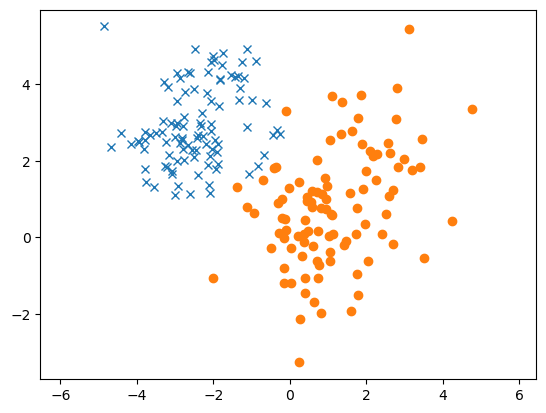

In [11]:
c1_x1, c1_x2 = np.random.multivariate_normal([-2.5,3], [[1, 0.3],[0.3, 1]], 100).T
c2_x1, c2_x2 = np.random.multivariate_normal([1,1], [[2, 1],[1, 2]], 100).T
c1_X = np.vstack((c1_x1, c1_x2)).T
c2_X = np.vstack((c2_x1, c2_x2)).T
train_X = np.concatenate((c1_X, c2_X))
train_y = np.concatenate((np.zeros(100), np.ones(100)))
# Shuffle the data
permutation = np.random.permutation(train_X.shape[0])
train_X = train_X[permutation, :]
train_y = train_y[permutation]
# Plot the data
plt.plot(c1_x1, c1_x2, 'x')
plt.plot(c2_x1, c2_x2, 'o')
plt.axis('equal')
plt.show()

We can then create a pytorch dataset object as follows. Often times, the default pytorch datasets will create these objects for you. Then, we can apply dataloaders to iterate over the dataset in batches.

In [12]:
dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_y))
# We can create a dataloader that iterates over the dataset in batches.
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
for x, y in dataloader:
    print("Batch x:", x)
    print("Batch y:", y)
    break

# Clean up the dataloader as we make a new one later
del dataloader

Batch x: tensor([[ 0.9686,  1.3430],
        [-0.4442,  2.6813],
        [ 0.5817,  0.7899],
        [-2.4630,  2.2918],
        [-0.9975,  3.5831],
        [-0.1511, -1.1903],
        [ 2.1704,  2.1242],
        [-1.1153,  4.9170],
        [-0.3242,  2.7991],
        [-3.0104,  2.6271]], dtype=torch.float64)
Batch y: tensor([1., 0., 1., 0., 0., 1., 1., 0., 0., 0.], dtype=torch.float64)


## Training Loop Example
Here is an example of training a full logistic regression model in pytorch. Note the extensive use of modules -- modules can be used for storing networks, computation steps etc.

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

epochs = 10
batch_size = 10
learning_rate = 0.01

num_features = dataset[0][0].shape[0]
model = Perceptron(num_features).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = torch.nn.BCELoss()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

model.train() # Put model in training mode
for epoch in range(epochs):
    training_losses = []
    for x, y in tqdm.notebook.tqdm(dataloader, unit="batch"):
        x, y = x.float().to(device), y.float().to(device)
        optimizer.zero_grad() # Remove the gradients from the previous step
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
    print("Finished Epoch", epoch + 1, ", training loss:", np.mean(training_losses))

# We can run predictions on the data to determine the final accuracy.
with torch.no_grad():
    model.eval() # Put model in eval mode
    num_correct = 0
    for x, y in dataloader:
        x, y = x.float().to(device), y.float().to(device)
        pred = model(x)
        num_correct += torch.sum(torch.round(pred) == y).item()
    print("Final Accuracy:", num_correct / len(dataset))
    model.train() # Put model back in train mode

Using device cuda


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 1 , training loss: 0.8502041846513748


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 2 , training loss: 0.6246297612786293


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 3 , training loss: 0.5098817721009254


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 4 , training loss: 0.44280029088258743


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 5 , training loss: 0.39779007583856585


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 6 , training loss: 0.36509873941540716


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 7 , training loss: 0.3400765560567379


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 8 , training loss: 0.31985427141189576


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 9 , training loss: 0.30341501981019975


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 10 , training loss: 0.28944102227687835
Final Accuracy: 0.92


# Task 1: MLP For FashionMNIST
Earlier in this course you trained SVMs and GDA models on MNIST. Now you will train a multi-layer perceptron model on an MNIST-like dataset. Your deliverables are as follows:

1. Code for training an MLP on MNIST (can be in code appendix, tagged in your submission).
2. A plot of the training loss and validation loss for each epoch of training after trainnig for at least 8 epochs.
3. A plot of the training and validation accuracy, showing that it is at least 82% for validation by the end of training.

Below we will create the training and validation datasets for you, and provide a very basic skeleton of the code. Please leverage the example training loop from above.

Some pytorch components you should definitely use:
1. `nn.Linear`
2. Some activation function like `nn.ReLU`
3. `nn.CrossEntropyLoss`: if you choose to use `nn.CrossEntropyLoss` or `F.cross_entropy`, DO NOT add an explicit softmax layer in your neural network. PyTorch devs found it more numerically stable to combine softmax and cross entropy loss into a single module and if you explicitly attach a softmax layer at the end of your model, you would unintentionally be applying it twice, which can degrade performance.

Here are challenges you will need to overcome:
1. The data is default configured in image form i.e. (1 x 28 x 28), versus one feature vector. You will need to reshape it somewhere to feed it in as vector to the MLP. There are many ways of doing this.
2. You need to write code for plotting.
3. You need to find appropriate hyper-parameters to achieve good accuracy.

Your underlying model must be fully connected or dense, and may not have convolutions etc., but you can use anything in torch.optim or any layers in torch.nn besides nn.Linear that do not have weights.

In [14]:
# Creating the datasets
transform = torchvision.transforms.ToTensor() # feel free to modify this as you see fit.

training_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

validation_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

Before training a neural network, let's visualize our data first! Running the cell below will display the first 9 images in a 3 by 3 grid.

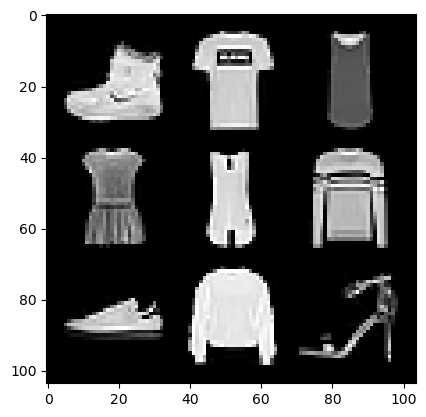

In [15]:
images = [training_data[i][0] for i in range(9)]
plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=3, padding=5).numpy().transpose((1, 2, 0)))

In [16]:
### YOUR CODE HERE ###
class MLP(nn.Module):
  def __init__(self, out_classes = 10):
    super().__init__()
    self.classifier = nn.Sequential(
        nn.Linear(in_features=28 * 28, out_features=224),
        nn.ReLU(),
        nn.Linear(224,56),
        nn.ReLU(),
        nn.Linear(56, out_classes)
    )
  def forward(self, x):
    x = self.classifier(x)
    return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

epochs = 10
batch_size = 100
learning_rate = 0.01

model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

model.train() # Put model in training mode
training_loss_per_epoch = []
val_loss_per_epoch = []
training_acc_per_epoch = []
val_acc_per_epoch = []

for epoch in range(epochs):

    training_losses = []
    for x, y in tqdm.notebook.tqdm(dataloader, unit="batch"):
        x = x.reshape(batch_size, -1)
        x, y = x.float().to(device), y.to(device)
        optimizer.zero_grad() # Remove the gradients from the previous step
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
    train_loss = np.mean(training_losses)
    training_loss_per_epoch.append(train_loss)

    print("Finished Epoch", epoch + 1)
    print("  training loss:", train_loss)

    with torch.no_grad():
        model.eval() # Put model in eval mode

        num_correct = 0
        for x, y in dataloader:
            x = x.reshape(batch_size, -1)
            x, y = x.float().to(device), y.to(device)
            pred = model(x)
            # print(pred)
            # print(y)
            # print(torch.argmax(pred, 1))
            num_correct += torch.sum(torch.round(torch.argmax(pred, 1)) == y).item()
        train_acc = num_correct / len(training_data)
        training_acc_per_epoch.append(train_acc)

        print("  training accuracy:", train_acc)

        num_correct = 0
        val_losses = []
        for x, y in valloader:
            x = x.reshape(batch_size, -1)
            x, y = x.float().to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            val_losses.append(loss.item())
            num_correct += torch.sum(torch.round(torch.argmax(pred, 1)) == y).item()
        val_loss = np.mean(val_losses)
        val_loss_per_epoch.append(val_loss)
        val_acc = num_correct / len(validation_data)
        val_acc_per_epoch.append(val_acc)

        print("  val loss:", val_loss)
        print("  val accuracy:", val_acc)

        model.train() # Put model back in train mode

Using device cuda


  0%|          | 0/600 [00:00<?, ?batch/s]

Finished Epoch 1
  training loss: 0.5241653733452161
  training accuracy: 0.838
  val loss: 0.48705738723278047
  val accuracy: 0.823


  0%|          | 0/600 [00:00<?, ?batch/s]

Finished Epoch 2
  training loss: 0.401827265098691
  training accuracy: 0.86315
  val loss: 0.42072718471288684
  val accuracy: 0.8473


  0%|          | 0/600 [00:00<?, ?batch/s]

Finished Epoch 3
  training loss: 0.36855001471936705
  training accuracy: 0.8695166666666667
  val loss: 0.42754876255989077
  val accuracy: 0.8523


  0%|          | 0/600 [00:00<?, ?batch/s]

Finished Epoch 4
  training loss: 0.3526244036853313
  training accuracy: 0.8761333333333333
  val loss: 0.4040031684935093
  val accuracy: 0.8563


  0%|          | 0/600 [00:00<?, ?batch/s]

Finished Epoch 5
  training loss: 0.3393847848723332
  training accuracy: 0.8866166666666667
  val loss: 0.3822024354338646
  val accuracy: 0.8648


  0%|          | 0/600 [00:00<?, ?batch/s]

Finished Epoch 6
  training loss: 0.3320114999016126
  training accuracy: 0.87815
  val loss: 0.40484062433242796
  val accuracy: 0.8555


  0%|          | 0/600 [00:00<?, ?batch/s]

Finished Epoch 7
  training loss: 0.3225970476989945
  training accuracy: 0.88885
  val loss: 0.38841118052601814
  val accuracy: 0.8617


  0%|          | 0/600 [00:00<?, ?batch/s]

Finished Epoch 8
  training loss: 0.31194329530000686
  training accuracy: 0.8912166666666667
  val loss: 0.38800138160586356
  val accuracy: 0.8656


  0%|          | 0/600 [00:00<?, ?batch/s]

Finished Epoch 9
  training loss: 0.3086671800663074
  training accuracy: 0.8862
  val loss: 0.41546852260828016
  val accuracy: 0.8669


  0%|          | 0/600 [00:00<?, ?batch/s]

Finished Epoch 10
  training loss: 0.30429815096159774
  training accuracy: 0.8859833333333333
  val loss: 0.4165012399852276
  val accuracy: 0.8569


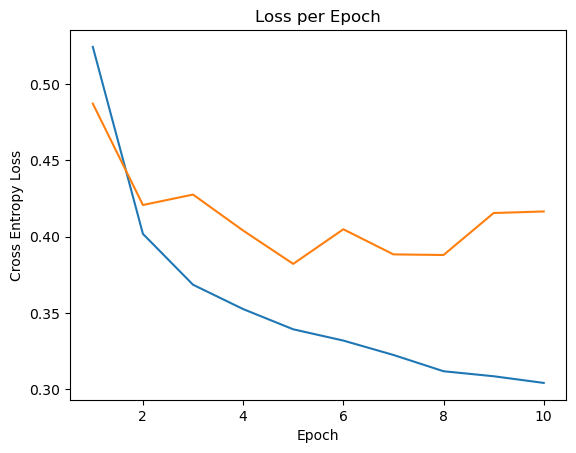

In [17]:
plt.plot(range(1, epochs + 1), training_loss_per_epoch, label="training")
plt.plot(range(1, epochs + 1), val_loss_per_epoch, label="validation")
plt.title("Loss per Epoch")
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.show()

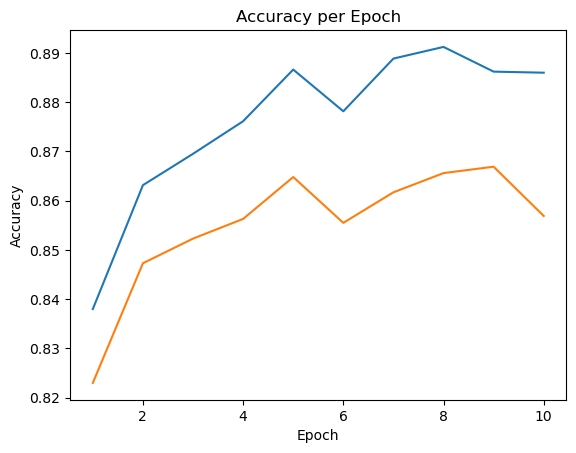

In [18]:
plt.plot(range(1, epochs + 1), training_acc_per_epoch, label="training")
plt.plot(range(1, epochs + 1), val_acc_per_epoch, label="validation")
plt.title("Accuracy per Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

# Task 2: CNNs for CIFAR-10

In this section, you will create a CNN for the CIFAR dataset, and submit your predictions to Kaggle. It is recommended that you use GPU acceleration for this part.

Here are some of the components you should consider using:
1. `nn.Conv2d`
2. `nn.ReLU`
3. `nn.Linear`
3. `nn.CrossEntropyLoss`: if you choose to use `nn.CrossEntropyLoss` or `F.cross_entropy`, DO NOT add an explicit softmax layer in your neural network. PyTorch devs found it more numerically stable to combine softmax and cross entropy loss into a single module and if you explicitly attach a softmax layer at the end of your model, you would unintentionally be applying it twice, which can degrade performance.
5. `nn.MaxPooling2d` (though many implementations without it exist; for example, you can also do strided convolutions instead of a pooling layer!)

We encourage you to explore different ways of improving your model to get higher accuracy. Here are some suggestions for things to look into:
1. CNN architectures: AlexNet, VGG, ResNets, etc.
2. Different optimizers and their parameters (see torch.optim)
3. Image preprocessing / data augmentation (see torchvision.transforms)
4. Regularization or dropout (see torch.optim and torch.nn respectively)
5. Learning rate scheduling: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
6. Weight initialization: https://pytorch.org/docs/stable/nn.init.html

Though we encourage you to explore, there are some rules:
1. You are not allowed to install or use packages not included by default in the Colab Environment.
2. You are not allowed to use any pre-defined architectures or feature extractors in your network.
3. You are not allowed to use **any** pretrained weights, ie no transfer learning.
4. You cannot train on the test data.

Otherwise everything is fair game.

Your deliverables are as follows:
1. Submit to Kaggle and include your test accuracy in your report.
2. Provide at least (1) training curve for your model, depicting loss per epoch or step after training for at least 8 epochs.
3. Explain the components of your final model, and how you think your design choices contributed to it's performance.

After you write your code, we have included skeleton code that should be used to submit predictions to Kaggle. **You must follow the instructions below under the submission header**. Note that if you apply any processing or transformations to the data, you will need to do the same to the test data otherwise you will likely achieve very low accuracy.

It is expected that this task will take a while to train. Our simple solution achieves a training accuracy of 90.2% and a test accuracy of 74.8% after 10 epochs (be careful of overfitting!). This easily beats the best SVM based CIFAR10 model submitted to the HW 1 Kaggle! It is possible to achieve 95% or higher test accuracy on CIFAR 10 with good model design and tuning.

In [70]:
# Creating the datasets, feel free to change this as long as you do the same to the test data.
# You can also modify this to split the data into training and validation.
# See https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

import torch.utils
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.2,0.2), scale=(0.95,1.05)),
    transforms.ToTensor()#,
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) #source: imagenet normalization
])

CIFAR10_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

transform = transforms.Compose([
    transforms.ToTensor()#,
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
# If you make a train-test partition it is up to you.

Files already downloaded and verified


In [71]:
print(len(CIFAR10_data))
training_data, validation_data = torch.utils.data.random_split(CIFAR10_data, (0.8, 0.2))
print(len(training_data))
print(len(validation_data))
print()

print(training_data[0][0].shape)

50000
47500
2500

torch.Size([3, 32, 32])


Again, let's first visualize our data.

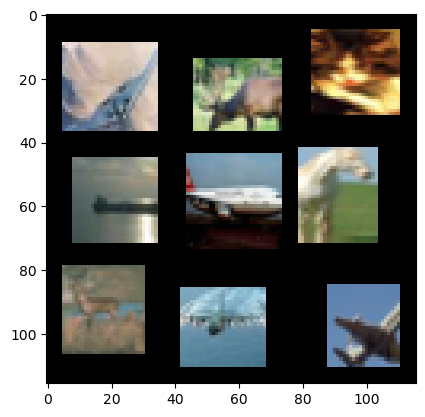

In [72]:
images = [training_data[i][0] for i in range(9)]
plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=3, padding=5).numpy().transpose((1, 2, 0)))

In [74]:
### YOUR CODE HERE ###

# source https://arxiv.org/abs/1512.03385
# + my personal spagetthi hell

class ResNetBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(ResNetBlock, self).__init__()
    self.CNN = nn.Sequential(
      nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(out_channels)
    )
    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=0),
        nn.BatchNorm2d(out_channels)
      )
    else:
      self.shortcut = lambda x: x
  
  def forward(self, x):
    out = self.CNN(x)
    out += self.shortcut(x)
    out = nn.ReLU()(out)
    return out

class ResNet(nn.Module):
  def __init__(self, in_channels = 3, out_classes = 10):
    super(ResNet, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        ResNetBlock(in_channels=8, out_channels=16),
        ResNetBlock(in_channels=16, out_channels=32),
        nn.MaxPool2d(kernel_size=2, stride=2),
        ResNetBlock(in_channels=32, out_channels=64),
        nn.MaxPool2d(kernel_size=2, stride=2),
        ResNetBlock(in_channels=64, out_channels=128),
        nn.MaxPool2d(kernel_size=2, stride=2),
        ResNetBlock(in_channels=128, out_channels=256),
        nn.MaxPool2d(kernel_size=2, stride=2),
        ResNetBlock(in_channels=256, out_channels=512),
    )
    self.classifier = nn.Sequential(
        nn.Linear(512 * 2 * 2, out_classes)
    )
  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x
  
#([{([{([{()}])}])}])#([{([{([{()}])}])}])#([{([{([{()}])}])}])#([{([{([{()}])}])}])#

# source: https://arxiv.org/abs/1603.05027
# + my personal mwuah

class PreActivationBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(PreActivationBlock, self).__init__()
    self.preactivation = nn.Sequential(
      nn.BatchNorm2d(in_channels),
      nn.ReLU()
    )
    self.CNN = nn.Sequential(
      nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False),
    )
    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, bias=False)
    else:
      self.shortcut = lambda x: x

  def forward(self, x):
    out = self.preactivation(x)
    shortcut = self.shortcut(out)
    out = self.CNN(out)
    out += shortcut
    return out

class PreActivationResNet(nn.Module):
  def __init__(self):
    super(PreActivationResNet, self).__init__()
    self.features = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
      PreActivationBlock(in_channels=64, out_channels=64),
      PreActivationBlock(in_channels=64, out_channels=64),
      PreActivationBlock(in_channels=64, out_channels=128, stride = 2), # 16 x 16
      PreActivationBlock(in_channels=128, out_channels=128),
      PreActivationBlock(in_channels=128, out_channels=256, stride = 2), # 8 x 8
      PreActivationBlock(in_channels=256, out_channels=256),
      PreActivationBlock(in_channels=256, out_channels=512,stride = 2), # 4 x 4
      PreActivationBlock(in_channels=512, out_channels=512),
      nn.AvgPool2d(kernel_size=4)
    )
    self.classifer = nn.Sequential(
      nn.Dropout(p=0.1),
      nn.Linear(512, 10)
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifer(x)
    return x
  
class PreActivationResNet34(nn.Module):
  def __init__(self):
    super(PreActivationResNet34, self).__init__()
    self.features = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
      PreActivationBlock(in_channels=64, out_channels=64),
      PreActivationBlock(in_channels=64, out_channels=64),
      PreActivationBlock(in_channels=64, out_channels=64),
      PreActivationBlock(in_channels=64, out_channels=128, stride = 2), # 16 x 16
      PreActivationBlock(in_channels=128, out_channels=128),
      PreActivationBlock(in_channels=128, out_channels=128),
      PreActivationBlock(in_channels=128, out_channels=128),
      PreActivationBlock(in_channels=128, out_channels=256, stride = 2), # 8 x 8
      PreActivationBlock(in_channels=256, out_channels=256),
      PreActivationBlock(in_channels=256, out_channels=256),
      PreActivationBlock(in_channels=256, out_channels=256),
      PreActivationBlock(in_channels=256, out_channels=256),
      PreActivationBlock(in_channels=256, out_channels=256),
      PreActivationBlock(in_channels=256, out_channels=512,stride = 2), # 4 x 4
      PreActivationBlock(in_channels=512, out_channels=512),
      PreActivationBlock(in_channels=512, out_channels=512),
      nn.AvgPool2d(kernel_size=4)
    )
    self.classifer = nn.Sequential(
      nn.Dropout(p=0.1),
      nn.Linear(512, 10)
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifer(x)
    return x
  
#([{([{([{()}])}])}])#([{([{([{()}])}])}])#([{([{([{()}])}])}])#([{([{([{()}])}])}])#

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

device = torch.device("cuda:2")

epochs = 160
batch_size = 100
learning_rate = 0.01

#model = ResNet().to(device)
model = PreActivationResNet().to(device)
#model = PreActivationResNet34().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=0.0002)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.CrossEntropyLoss()
dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

model.train() # Put model in training mode
training_loss_per_epoch = []
val_loss_per_epoch = []
training_acc_per_epoch = []
val_acc_per_epoch = []

for epoch in range(epochs):
  training_losses = []
  num_correct = 0
  for x, y in tqdm.notebook.tqdm(dataloader, unit="batch"):
      x, y = x.float().to(device), y.to(device)
      optimizer.zero_grad() # Remove the gradients from the previous step
      pred = model(x)
      loss = criterion(pred, y)
      loss.backward()
      optimizer.step()
      training_losses.append(loss.item())
      num_correct += torch.sum(torch.round(torch.argmax(pred, 1)) == y).item()
  scheduler.step()

  train_loss = np.mean(training_losses)
  training_loss_per_epoch.append(train_loss)
  train_acc = num_correct / len(training_data)
  training_acc_per_epoch.append(train_acc)

  print("Finished Epoch", epoch + 1)
  print("  training loss:", train_loss)
  print("  training accuracy:", train_acc)

  #if (epoch + 1) % 10 == 0:
  with torch.no_grad():
      model.eval() # Put model in eval mode

      # num_correct = 0
      # for x, y in dataloader:
      #     x, y = x.float().to(device), y.to(device)
      #     pred = model(x)
      #     # print(pred)
      #     # print(y)
      #     # print(torch.argmax(pred, 1))
      #     num_correct += torch.sum(torch.round(torch.argmax(pred, 1)) == y).item()
      # train_acc = num_correct / len(training_data)
      # training_acc_per_epoch.append(train_acc)

      # print("  training accuracy:", train_acc)

      num_correct = 0
      val_losses = []
      for x, y in valloader:
          x, y = x.float().to(device), y.to(device)
          pred = model(x)
          loss = criterion(pred, y)
          val_losses.append(loss.item())
          num_correct += torch.sum(torch.round(torch.argmax(pred, 1)) == y).item()
      val_loss = np.mean(val_losses)
      val_loss_per_epoch.append(val_loss)
      val_acc = num_correct / len(validation_data)
      val_acc_per_epoch.append(val_acc)

      print("  val loss:", val_loss)
      print("  val accuracy:", val_acc)

      model.train() # Put model back in train mode

Using device cuda


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 1
  training loss: 2.43227972080833
  training accuracy: 0.15661052631578948
  val loss: 2.0954378128051756
  val accuracy: 0.2064


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 2
  training loss: 1.8985135369551809
  training accuracy: 0.25242105263157893
  val loss: 1.9060497713088989
  val accuracy: 0.2484


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 3
  training loss: 1.754695637602555
  training accuracy: 0.3160631578947368
  val loss: 3.4292912101745605
  val accuracy: 0.1644


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 4
  training loss: 1.5751604388889513
  training accuracy: 0.40353684210526314
  val loss: 1.6220122623443602
  val accuracy: 0.4056


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 5
  training loss: 1.3983268075240285
  training accuracy: 0.4868421052631579
  val loss: 1.578732442855835
  val accuracy: 0.42


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 6
  training loss: 1.2763883472743787
  training accuracy: 0.5364421052631579
  val loss: 1.4767318773269653
  val accuracy: 0.4832


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 7
  training loss: 1.1740134372209248
  training accuracy: 0.5761894736842105
  val loss: 2.073937749862671
  val accuracy: 0.3984


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 8
  training loss: 1.0803545963136774
  training accuracy: 0.6134736842105263
  val loss: 1.1585850310325623
  val accuracy: 0.5668


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 9
  training loss: 0.9886460149915595
  training accuracy: 0.6489052631578948
  val loss: 1.4198113107681274
  val accuracy: 0.5244


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 10
  training loss: 0.9250219860829805
  training accuracy: 0.6739157894736842
  val loss: 1.1042267179489136
  val accuracy: 0.6268


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 11
  training loss: 0.8601183453359101
  training accuracy: 0.6985473684210526
  val loss: 0.9274824070930481
  val accuracy: 0.6652


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 12
  training loss: 0.8029683391671432
  training accuracy: 0.7183157894736842
  val loss: 0.8343932032585144
  val accuracy: 0.7088


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 13
  training loss: 0.7554000339382573
  training accuracy: 0.7362105263157894
  val loss: 0.9250007009506226
  val accuracy: 0.6784


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 14
  training loss: 0.7130575053315413
  training accuracy: 0.7509684210526316
  val loss: 0.7855635929107666
  val accuracy: 0.7216


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 15
  training loss: 0.6648840409830997
  training accuracy: 0.7678105263157895
  val loss: 0.9261862063407897
  val accuracy: 0.7068


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 16
  training loss: 0.6362531119898746
  training accuracy: 0.7788842105263157
  val loss: 0.7393876564502716
  val accuracy: 0.7408


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 17
  training loss: 0.5956726871666156
  training accuracy: 0.792021052631579
  val loss: 0.723180490732193
  val accuracy: 0.7484


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 18
  training loss: 0.5699391273448342
  training accuracy: 0.8035368421052631
  val loss: 0.6068066024780273
  val accuracy: 0.7872


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 19
  training loss: 0.5346403859791002
  training accuracy: 0.8164631578947369
  val loss: 0.7235189247131347
  val accuracy: 0.7568


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 20
  training loss: 0.5083161032827277
  training accuracy: 0.8252631578947368
  val loss: 0.5817235767841339
  val accuracy: 0.8004


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 21
  training loss: 0.514750808665627
  training accuracy: 0.8221052631578948
  val loss: 0.6200182783603668
  val accuracy: 0.7768


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 22
  training loss: 0.4631695484487634
  training accuracy: 0.8390526315789474
  val loss: 0.544135810136795
  val accuracy: 0.8124


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 23
  training loss: 0.44044225510798
  training accuracy: 0.8478105263157895
  val loss: 0.5142561423778534
  val accuracy: 0.8192


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 24
  training loss: 0.4184633346921519
  training accuracy: 0.8553684210526316
  val loss: 0.603927628993988
  val accuracy: 0.7896


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 25
  training loss: 0.39939110530050176
  training accuracy: 0.8622526315789474
  val loss: 0.5968596315383912
  val accuracy: 0.8076


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 26
  training loss: 0.38407470762729645
  training accuracy: 0.8672631578947368
  val loss: 0.4507007342576981
  val accuracy: 0.836


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 27
  training loss: 0.3661165319618426
  training accuracy: 0.8724421052631579
  val loss: 0.44314639508724213
  val accuracy: 0.8428


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 28
  training loss: 0.3520070082576651
  training accuracy: 0.8771789473684211
  val loss: 0.4761685800552368
  val accuracy: 0.8304


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 29
  training loss: 0.3374888738205558
  training accuracy: 0.8837894736842106
  val loss: 0.5307791578769684
  val accuracy: 0.8164


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 30
  training loss: 0.33058353480539826
  training accuracy: 0.8864842105263158
  val loss: 0.42893063187599184
  val accuracy: 0.8528


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 31
  training loss: 0.3067736043898683
  training accuracy: 0.893621052631579
  val loss: 0.4325132739543915
  val accuracy: 0.8584


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 32
  training loss: 0.47393693550636895
  training accuracy: 0.8448
  val loss: 0.4606314712762833
  val accuracy: 0.8392


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 33
  training loss: 0.32521047659610447
  training accuracy: 0.8870526315789473
  val loss: 0.4518866044282913
  val accuracy: 0.8424


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 34
  training loss: 0.2827177406925904
  training accuracy: 0.9025052631578947
  val loss: 0.48790504932403567
  val accuracy: 0.8392


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 35
  training loss: 0.2708890257697356
  training accuracy: 0.9047578947368421
  val loss: 0.4271555149555206
  val accuracy: 0.8544


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 36
  training loss: 0.2569489668231261
  training accuracy: 0.9102736842105263
  val loss: 0.44129387617111204
  val accuracy: 0.856


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 37
  training loss: 0.24500044386637837
  training accuracy: 0.9145263157894736
  val loss: 0.4595673453807831
  val accuracy: 0.8508


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 38
  training loss: 0.2397092527307962
  training accuracy: 0.9162947368421053
  val loss: 0.3913769295811653
  val accuracy: 0.8756


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 39
  training loss: 0.23203555111038057
  training accuracy: 0.9178736842105263
  val loss: 0.41979405462741853
  val accuracy: 0.8624


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 40
  training loss: 0.22866647628577133
  training accuracy: 0.9203789473684211
  val loss: 0.44029602348804475
  val accuracy: 0.848


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 41
  training loss: 0.21767810507824548
  training accuracy: 0.924021052631579
  val loss: 0.3938195294141769
  val accuracy: 0.8644


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 42
  training loss: 0.2107691909137525
  training accuracy: 0.9256842105263158
  val loss: 0.4083068978786468
  val accuracy: 0.8668


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 43
  training loss: 0.23936464678300054
  training accuracy: 0.9163789473684211
  val loss: 0.4107649940252304
  val accuracy: 0.8696


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 44
  training loss: 0.19416889890244132
  training accuracy: 0.9322947368421053
  val loss: 0.3911406746506691
  val accuracy: 0.8836


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 45
  training loss: 0.3503751833031052
  training accuracy: 0.8894315789473685
  val loss: 0.48909955501556396
  val accuracy: 0.8404


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 46
  training loss: 0.2687404756326424
  training accuracy: 0.9069263157894737
  val loss: 0.35436773777008057
  val accuracy: 0.8828


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 47
  training loss: 0.1895141087550866
  training accuracy: 0.9314105263157895
  val loss: 0.41891601324081423
  val accuracy: 0.8676


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 48
  training loss: 0.169348430962939
  training accuracy: 0.9409684210526316
  val loss: 0.37184087485074996
  val accuracy: 0.8808


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 49
  training loss: 0.15864392082157888
  training accuracy: 0.9446315789473684
  val loss: 0.3974280586838722
  val accuracy: 0.8816


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 50
  training loss: 0.15541232506695546
  training accuracy: 0.9459157894736843
  val loss: 0.3694465607404709
  val accuracy: 0.8884


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 51
  training loss: 0.15654646716227658
  training accuracy: 0.9449263157894737
  val loss: 0.39580544173717497
  val accuracy: 0.8788


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 52
  training loss: 0.15233494524108737
  training accuracy: 0.9466947368421053
  val loss: 0.39554956674575803
  val accuracy: 0.874


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 53
  training loss: 0.14768563044698615
  training accuracy: 0.9489052631578947
  val loss: 0.37763974249362947
  val accuracy: 0.884


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 54
  training loss: 0.14262786353889265
  training accuracy: 0.949221052631579
  val loss: 0.3979766657948494
  val accuracy: 0.8728


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 55
  training loss: 0.1405289825326518
  training accuracy: 0.9517473684210527
  val loss: 0.3778265827894211
  val accuracy: 0.8896


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 56
  training loss: 0.14934162248906335
  training accuracy: 0.9477684210526316
  val loss: 0.3800313758850098
  val accuracy: 0.8888


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 57
  training loss: 0.13039467586498513
  training accuracy: 0.9549684210526316
  val loss: 0.3893830907344818
  val accuracy: 0.8868


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 58
  training loss: 0.126294722525697
  training accuracy: 0.9553684210526315
  val loss: 0.37960994720458985
  val accuracy: 0.8888


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 59
  training loss: 0.12257089368999004
  training accuracy: 0.9567368421052631
  val loss: 0.42885191202163697
  val accuracy: 0.8852


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 60
  training loss: 0.11940961795417886
  training accuracy: 0.9578315789473684
  val loss: 0.3930558767914772
  val accuracy: 0.8876


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 61
  training loss: 0.11656468653365186
  training accuracy: 0.9598736842105263
  val loss: 0.4705409622192383
  val accuracy: 0.8692


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 62
  training loss: 0.11525474163654603
  training accuracy: 0.9594947368421053
  val loss: 0.5165852159261703
  val accuracy: 0.8604


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 63
  training loss: 0.10768921849562933
  training accuracy: 0.9625684210526316
  val loss: 0.43837429165840147
  val accuracy: 0.8784


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 64
  training loss: 0.10534160126588847
  training accuracy: 0.9630736842105263
  val loss: 0.43579164385795593
  val accuracy: 0.8756


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 65
  training loss: 0.09909160977131443
  training accuracy: 0.965221052631579
  val loss: 0.4940160495042801
  val accuracy: 0.8828


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 66
  training loss: 0.09942231935497961
  training accuracy: 0.9647578947368421
  val loss: 0.40800598859786985
  val accuracy: 0.878


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 67
  training loss: 0.09862171830511407
  training accuracy: 0.9652842105263157
  val loss: 0.4082793155312538
  val accuracy: 0.8852


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 68
  training loss: 0.09496682348023903
  training accuracy: 0.9662315789473684
  val loss: 0.4067790514230728
  val accuracy: 0.8892


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 69
  training loss: 0.09350830208706229
  training accuracy: 0.9674736842105263
  val loss: 0.4393789213895798
  val accuracy: 0.8844


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 70
  training loss: 0.14600428928277995
  training accuracy: 0.9538736842105263
  val loss: 0.4072778007388115
  val accuracy: 0.8864


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 71
  training loss: 0.08624785219368182
  training accuracy: 0.9698105263157895
  val loss: 0.4076232072710991
  val accuracy: 0.89


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 72
  training loss: 0.08190301757501929
  training accuracy: 0.9712421052631579
  val loss: 0.4412128698825836
  val accuracy: 0.8852


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 73
  training loss: 0.0781942646048571
  training accuracy: 0.9733684210526315
  val loss: 0.37949617266654967
  val accuracy: 0.9012


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 74
  training loss: 0.09120857546400082
  training accuracy: 0.9685894736842106
  val loss: 0.5156506729125977
  val accuracy: 0.8776


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 75
  training loss: 0.07705705976211712
  training accuracy: 0.9736
  val loss: 0.4078154402971268
  val accuracy: 0.8936


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 76
  training loss: 0.07263561504843988
  training accuracy: 0.9750736842105263
  val loss: 0.4134872102737427
  val accuracy: 0.8872


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 77
  training loss: 0.0790031069575956
  training accuracy: 0.9726736842105264
  val loss: 0.39312641203403476
  val accuracy: 0.8932


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 78
  training loss: 0.06953838105852667
  training accuracy: 0.9750947368421052
  val loss: 0.40720773667097093
  val accuracy: 0.892


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 79
  training loss: 0.07174502529988164
  training accuracy: 0.9752631578947368
  val loss: 0.39185856431722643
  val accuracy: 0.8844


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 80
  training loss: 0.07666573625057936
  training accuracy: 0.9737263157894737
  val loss: 0.40919551968574525
  val accuracy: 0.8888


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 81
  training loss: 0.06708120536157175
  training accuracy: 0.9760842105263158
  val loss: 0.40855429619550704
  val accuracy: 0.8952


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 82
  training loss: 0.06681625865301803
  training accuracy: 0.9767157894736842
  val loss: 0.46506301164627073
  val accuracy: 0.8868


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 83
  training loss: 0.061404819395393134
  training accuracy: 0.9785894736842106
  val loss: 0.4025671616196632
  val accuracy: 0.9004


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 84
  training loss: 0.0579882978652849
  training accuracy: 0.9799789473684211
  val loss: 0.480107324719429
  val accuracy: 0.8904


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 85
  training loss: 0.0614607160440401
  training accuracy: 0.9789052631578947
  val loss: 0.43444015383720397
  val accuracy: 0.8912


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 86
  training loss: 0.0591961454158943
  training accuracy: 0.9793684210526316
  val loss: 0.45504541873931886
  val accuracy: 0.888


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 87
  training loss: 0.05766113012636963
  training accuracy: 0.9797052631578947
  val loss: 0.4411103862524033
  val accuracy: 0.8936


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 88
  training loss: 0.05578265588044336
  training accuracy: 0.9815578947368421
  val loss: 0.39529760360717775
  val accuracy: 0.898


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 89
  training loss: 0.05464156963421326
  training accuracy: 0.9812
  val loss: 0.48814339756965636
  val accuracy: 0.8796


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 90
  training loss: 0.055801880013099624
  training accuracy: 0.9808631578947369
  val loss: 0.4429068550467491
  val accuracy: 0.8912


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 91
  training loss: 0.06001000949377684
  training accuracy: 0.9795578947368421
  val loss: 0.42412648141384124
  val accuracy: 0.9


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 92
  training loss: 0.050536991969045056
  training accuracy: 0.9822315789473685
  val loss: 0.4233050811290741
  val accuracy: 0.902


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 93
  training loss: 0.05209291288139004
  training accuracy: 0.9812421052631579
  val loss: 0.4805236494541168
  val accuracy: 0.8904


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 94
  training loss: 0.04700929385070738
  training accuracy: 0.9844421052631579
  val loss: 0.4311276930570602
  val accuracy: 0.8976


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 95
  training loss: 0.05026063749517657
  training accuracy: 0.9829473684210527
  val loss: 0.46204034686088563
  val accuracy: 0.8944


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 96
  training loss: 0.0474054882842067
  training accuracy: 0.9838947368421053
  val loss: 0.47514344096183775
  val accuracy: 0.8988


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 97
  training loss: 0.04360755437004723
  training accuracy: 0.9844842105263157
  val loss: 0.4289655900001526
  val accuracy: 0.8984


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 98
  training loss: 0.04522430088787683
  training accuracy: 0.9850736842105263
  val loss: 0.47321278154850005
  val accuracy: 0.8928


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 99
  training loss: 0.04212766091682409
  training accuracy: 0.9852421052631579
  val loss: 0.47356816232204435
  val accuracy: 0.894


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 100
  training loss: 0.04205357741907631
  training accuracy: 0.9853894736842105
  val loss: 0.4494748514890671
  val accuracy: 0.9012


In [78]:
# I ran this cell a couple times to manually run epochs until getting a desired val acc
last = epoch

for epoch in range(last + 1, last + 1 + 48):
  training_losses = []
  num_correct = 0
  for x, y in tqdm.notebook.tqdm(dataloader, unit="batch"):
      x, y = x.float().to(device), y.to(device)
      #x = nn.Dropout(p=0.05)(x)
      optimizer.zero_grad() # Remove the gradients from the previous step
      pred = model(x)
      loss = criterion(pred, y)
      loss.backward()
      optimizer.step()
      training_losses.append(loss.item())
      num_correct += torch.sum(torch.round(torch.argmax(pred, 1)) == y).item()
  scheduler.step()

  train_loss = np.mean(training_losses)
  training_loss_per_epoch.append(train_loss)
  train_acc = num_correct / len(training_data)
  training_acc_per_epoch.append(train_acc)

  print("Finished Epoch", epoch + 1)
  print("  training loss:", train_loss)
  print("  training accuracy:", train_acc)

  #if (epoch + 1) % 10 == 0:
  with torch.no_grad():
      model.eval() # Put model in eval mode

      # num_correct = 0
      # for x, y in dataloader:
      #     x, y = x.float().to(device), y.to(device)
      #     pred = model(x)
      #     # print(pred)
      #     # print(y)
      #     # print(torch.argmax(pred, 1))
      #     num_correct += torch.sum(torch.round(torch.argmax(pred, 1)) == y).item()
      # train_acc = num_correct / len(training_data)
      # training_acc_per_epoch.append(train_acc)

      # print("  training accuracy:", train_acc)

      num_correct = 0
      val_losses = []
      for x, y in valloader:
          x, y = x.float().to(device), y.to(device)
          #x = nn.Dropout(p=0.05)(x)
          pred = model(x)
          loss = criterion(pred, y)
          val_losses.append(loss.item())
          num_correct += torch.sum(torch.round(torch.argmax(pred, 1)) == y).item()
      val_loss = np.mean(val_losses)
      val_loss_per_epoch.append(val_loss)
      val_acc = num_correct / len(validation_data)
      val_acc_per_epoch.append(val_acc)

      print("  val loss:", val_loss)
      print("  val accuracy:", val_acc)

      model.train() # Put model back in train mode

  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 203
  training loss: 0.03815268580458666
  training accuracy: 0.9875368421052632
  val loss: 0.353956139087677
  val accuracy: 0.9012


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 204
  training loss: 0.03696847011678313
  training accuracy: 0.9885263157894737
  val loss: 0.3194808965921402
  val accuracy: 0.9036


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 205
  training loss: 0.037128802148723286
  training accuracy: 0.9885052631578948
  val loss: 0.34678676128387453
  val accuracy: 0.8988


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 206
  training loss: 0.03699932061920041
  training accuracy: 0.9878526315789473
  val loss: 0.35570001661777495
  val accuracy: 0.8988


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 207
  training loss: 0.038377199998419535
  training accuracy: 0.9883578947368421
  val loss: 0.31947685360908507
  val accuracy: 0.9056


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 208
  training loss: 0.03468330749751706
  training accuracy: 0.989621052631579
  val loss: 0.3464591562747955
  val accuracy: 0.8996


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 209
  training loss: 0.03160224805438989
  training accuracy: 0.9900631578947369
  val loss: 0.35059732794761655
  val accuracy: 0.9036


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 210
  training loss: 0.030777254489397533
  training accuracy: 0.9905052631578948
  val loss: 0.3498315471410751
  val accuracy: 0.9032


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 211
  training loss: 0.0294772099936381
  training accuracy: 0.9913473684210526
  val loss: 0.3447584593296051
  val accuracy: 0.9028


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 212
  training loss: 0.02777535210020448
  training accuracy: 0.9915368421052632
  val loss: 0.3416173568367958
  val accuracy: 0.9032


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 213
  training loss: 0.026004507370097074
  training accuracy: 0.9918526315789473
  val loss: 0.3594570749998093
  val accuracy: 0.9016


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 214
  training loss: 0.023704244654723688
  training accuracy: 0.9919789473684211
  val loss: 0.3689055722951889
  val accuracy: 0.9024


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 215
  training loss: 0.02222790347828873
  training accuracy: 0.9925263157894737
  val loss: 0.3716967165470123
  val accuracy: 0.9092


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 216
  training loss: 0.020812128200440816
  training accuracy: 0.9934105263157895
  val loss: 0.3919852125644684
  val accuracy: 0.9044


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 217
  training loss: 0.021120556105222357
  training accuracy: 0.9936842105263158
  val loss: 0.3617634630203247
  val accuracy: 0.9048


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 218
  training loss: 0.018461349129211158
  training accuracy: 0.9942736842105263
  val loss: 0.39988946586847307
  val accuracy: 0.9024


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 219
  training loss: 0.018362086339437058
  training accuracy: 0.9938105263157895
  val loss: 0.37843391686677935
  val accuracy: 0.9068


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 220
  training loss: 0.01590482910041158
  training accuracy: 0.9947368421052631
  val loss: 0.3803469294309616
  val accuracy: 0.9164


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 221
  training loss: 0.016407758479594792
  training accuracy: 0.9946105263157895
  val loss: 0.3703430908918381
  val accuracy: 0.9084


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 222
  training loss: 0.01519950084109472
  training accuracy: 0.9948
  val loss: 0.3890736144781113
  val accuracy: 0.91


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 223
  training loss: 0.014818236609632884
  training accuracy: 0.9953263157894737
  val loss: 0.43907852172851564
  val accuracy: 0.9084


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 224
  training loss: 0.01632461561325104
  training accuracy: 0.9948
  val loss: 0.37554681330919265
  val accuracy: 0.9164


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 225
  training loss: 0.0142683414277302
  training accuracy: 0.9950315789473684
  val loss: 0.401764535009861
  val accuracy: 0.9132


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 226
  training loss: 0.01348197754340761
  training accuracy: 0.9954526315789474
  val loss: 0.40336443692445756
  val accuracy: 0.91


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 227
  training loss: 0.013963111277400075
  training accuracy: 0.9954105263157895
  val loss: 0.409988796710968
  val accuracy: 0.9132


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 228
  training loss: 0.014731785230511664
  training accuracy: 0.9954315789473684
  val loss: 0.401312458217144
  val accuracy: 0.9084


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 229
  training loss: 0.012644761950911122
  training accuracy: 0.9959578947368422
  val loss: 0.413265363574028
  val accuracy: 0.9148


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 230
  training loss: 0.013466897959848498
  training accuracy: 0.9952842105263158
  val loss: 0.406158806681633
  val accuracy: 0.9124


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 231
  training loss: 0.011638824092561232
  training accuracy: 0.9959157894736842
  val loss: 0.40229272037744523
  val accuracy: 0.914


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 232
  training loss: 0.011545798142691828
  training accuracy: 0.996378947368421
  val loss: 0.40743390113115313
  val accuracy: 0.9128


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 233
  training loss: 0.011902119075285125
  training accuracy: 0.9959789473684211
  val loss: 0.40882915645837786
  val accuracy: 0.92


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 234
  training loss: 0.012165680902728222
  training accuracy: 0.9957684210526315
  val loss: 0.41467845112085344
  val accuracy: 0.9136


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 235
  training loss: 0.010958684416867695
  training accuracy: 0.9965052631578948
  val loss: 0.4175881186127663
  val accuracy: 0.9132


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 236
  training loss: 0.011823615093177834
  training accuracy: 0.996
  val loss: 0.4117323963344097
  val accuracy: 0.9156


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 237
  training loss: 0.011582437175322986
  training accuracy: 0.9962315789473685
  val loss: 0.42417414352297783
  val accuracy: 0.91


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 238
  training loss: 0.01076383613126573
  training accuracy: 0.9963157894736843
  val loss: 0.4624079340696335
  val accuracy: 0.91


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 239
  training loss: 0.011259153739711588
  training accuracy: 0.9961473684210527
  val loss: 0.4303346502780914
  val accuracy: 0.9108


  0%|          | 0/475 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [79]:
new_data, super_validation_data = torch.utils.data.random_split(validation_data, (0.4, 0.6))
print(len(new_data))
print(len(super_validation_data))

newloader = torch.utils.data.DataLoader(new_data, batch_size=batch_size, shuffle=True)
supervalloader = torch.utils.data.DataLoader(super_validation_data, batch_size=batch_size)

1000
1500


In [82]:
# Maybe new data will allow it to "fine tune"
last = epoch

for epoch in range(last + 1, last + 1 + 48):
  training_losses = []
  num_correct = 0
  for x, y in tqdm.notebook.tqdm(newloader, unit="batch"):
      x, y = x.float().to(device), y.to(device)
      #x = nn.Dropout(p=0.05)(x)
      optimizer.zero_grad() # Remove the gradients from the previous step
      pred = model(x)
      loss = criterion(pred, y)
      loss.backward()
      optimizer.step()
      training_losses.append(loss.item())
      num_correct += torch.sum(torch.round(torch.argmax(pred, 1)) == y).item()
  scheduler.step()

  train_loss = np.mean(training_losses)
  training_loss_per_epoch.append(train_loss)
  train_acc = num_correct / len(new_data)
  training_acc_per_epoch.append(train_acc)

  print("Finished Epoch", epoch + 1)
  print("  training loss:", train_loss)
  print("  training accuracy:", train_acc)

  #if (epoch + 1) % 10 == 0:
  with torch.no_grad():
      model.eval() # Put model in eval mode

      # num_correct = 0
      # for x, y in dataloader:
      #     x, y = x.float().to(device), y.to(device)
      #     pred = model(x)
      #     # print(pred)
      #     # print(y)
      #     # print(torch.argmax(pred, 1))
      #     num_correct += torch.sum(torch.round(torch.argmax(pred, 1)) == y).item()
      # train_acc = num_correct / len(training_data)
      # training_acc_per_epoch.append(train_acc)

      # print("  training accuracy:", train_acc)

      num_correct = 0
      val_losses = []
      for x, y in supervalloader:
          x, y = x.float().to(device), y.to(device)
          #x = nn.Dropout(p=0.05)(x)
          pred = model(x)
          loss = criterion(pred, y)
          val_losses.append(loss.item())
          num_correct += torch.sum(torch.round(torch.argmax(pred, 1)) == y).item()
      val_loss = np.mean(val_losses)
      val_loss_per_epoch.append(val_loss)
      val_acc = num_correct / len(super_validation_data)
      val_acc_per_epoch.append(val_acc)

      print("  val loss:", val_loss)
      print("  val accuracy:", val_acc)

      model.train() # Put model back in train mode

  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 266
  training loss: 0.0295312843285501
  training accuracy: 0.991
  val loss: 0.4693951328595479
  val accuracy: 0.892


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 267
  training loss: 0.023386491183191537
  training accuracy: 0.994
  val loss: 0.5315933426221212
  val accuracy: 0.882


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 268
  training loss: 0.023546538874506952
  training accuracy: 0.997
  val loss: 0.4378888209660848
  val accuracy: 0.9053333333333333


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 269
  training loss: 0.01129822338698432
  training accuracy: 0.998
  val loss: 0.4035599519809087
  val accuracy: 0.908


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 270
  training loss: 0.026319930609315634
  training accuracy: 0.992
  val loss: 0.4650260875622431
  val accuracy: 0.9066666666666666


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 271
  training loss: 0.014732734579592944
  training accuracy: 0.994
  val loss: 0.4524464746316274
  val accuracy: 0.8993333333333333


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 272
  training loss: 0.014212558488361537
  training accuracy: 0.994
  val loss: 0.4556477894385656
  val accuracy: 0.9006666666666666


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 273
  training loss: 0.018120367429219186
  training accuracy: 0.994
  val loss: 0.4275400459766388
  val accuracy: 0.9093333333333333


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 274
  training loss: 0.013448007986880839
  training accuracy: 0.996
  val loss: 0.4932879110177358
  val accuracy: 0.8953333333333333


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 275
  training loss: 0.012202473659999668
  training accuracy: 0.997
  val loss: 0.49046033024787905
  val accuracy: 0.8993333333333333


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 276
  training loss: 0.014503471757052466
  training accuracy: 0.997
  val loss: 0.4467753996451696
  val accuracy: 0.898


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 277
  training loss: 0.010831101483199745
  training accuracy: 0.996
  val loss: 0.42621509234110516
  val accuracy: 0.9013333333333333


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 278
  training loss: 0.02335435040295124
  training accuracy: 0.993
  val loss: 0.46486439804236096
  val accuracy: 0.8946666666666667


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 279
  training loss: 0.012283273320645095
  training accuracy: 0.996
  val loss: 0.4626857767502467
  val accuracy: 0.9066666666666666


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 280
  training loss: 0.015293089556507766
  training accuracy: 0.995
  val loss: 0.4925652533769608
  val accuracy: 0.906


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 281
  training loss: 0.01305412920191884
  training accuracy: 0.996
  val loss: 0.49414647022883096
  val accuracy: 0.8986666666666666


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 282
  training loss: 0.013553402328398079
  training accuracy: 0.995
  val loss: 0.5191929340362549
  val accuracy: 0.896


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 283
  training loss: 0.020463240472599863
  training accuracy: 0.994
  val loss: 0.4730213224887848
  val accuracy: 0.8946666666666667


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 284
  training loss: 0.023744349391199647
  training accuracy: 0.993
  val loss: 0.4949896196524302
  val accuracy: 0.898


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 285
  training loss: 0.00583160780952312
  training accuracy: 0.999
  val loss: 0.5141972661018371
  val accuracy: 0.894


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 286
  training loss: 0.013486728732823394
  training accuracy: 0.996
  val loss: 0.48405864735444387
  val accuracy: 0.9006666666666666


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 287
  training loss: 0.02613307723077014
  training accuracy: 0.995
  val loss: 0.5161253442366918
  val accuracy: 0.888


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 288
  training loss: 0.013562318799085916
  training accuracy: 0.995
  val loss: 0.5033806373675664
  val accuracy: 0.886


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 289
  training loss: 0.010312523972243071
  training accuracy: 0.997
  val loss: 0.5815049449602763
  val accuracy: 0.8886666666666667


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 290
  training loss: 0.020194859849289058
  training accuracy: 0.992
  val loss: 0.5140937129656474
  val accuracy: 0.8933333333333333


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 291
  training loss: 0.015197744735633022
  training accuracy: 0.994
  val loss: 0.5402100543181102
  val accuracy: 0.8873333333333333


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 292
  training loss: 0.022594594722613694
  training accuracy: 0.994
  val loss: 0.4883056829373042
  val accuracy: 0.9006666666666666


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 293
  training loss: 0.01655819013249129
  training accuracy: 0.993
  val loss: 0.5762169122695923
  val accuracy: 0.888


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 294
  training loss: 0.015351047506555915
  training accuracy: 0.994
  val loss: 0.5504438201586406
  val accuracy: 0.8906666666666667


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 295
  training loss: 0.013919013598933817
  training accuracy: 0.994
  val loss: 0.5358304818471272
  val accuracy: 0.884


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 296
  training loss: 0.012668282148661092
  training accuracy: 0.996
  val loss: 0.6284273962179819
  val accuracy: 0.8806666666666667


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 297
  training loss: 0.01951282229856588
  training accuracy: 0.991
  val loss: 0.5790772636731466
  val accuracy: 0.89


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 298
  training loss: 0.005648667656350881
  training accuracy: 0.999
  val loss: 0.530618304014206
  val accuracy: 0.894


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 299
  training loss: 0.01675294595770538
  training accuracy: 0.996
  val loss: 0.5361282130082449
  val accuracy: 0.8893333333333333


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 300
  training loss: 0.019616532861255108
  training accuracy: 0.99
  val loss: 0.5812288423379263
  val accuracy: 0.8873333333333333


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 301
  training loss: 0.022397666628239676
  training accuracy: 0.993
  val loss: 0.5431313355763753
  val accuracy: 0.8973333333333333


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 302
  training loss: 0.010558480548206716
  training accuracy: 0.998
  val loss: 0.5379847973585129
  val accuracy: 0.888


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 303
  training loss: 0.018340117705520242
  training accuracy: 0.995
  val loss: 0.5636156876881917
  val accuracy: 0.8893333333333333


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 304
  training loss: 0.01690127478213981
  training accuracy: 0.994
  val loss: 0.6134109675884247
  val accuracy: 0.8693333333333333


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 305
  training loss: 0.013245662188273855
  training accuracy: 0.995
  val loss: 0.566735565662384
  val accuracy: 0.888


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 306
  training loss: 0.010408492357237264
  training accuracy: 0.996
  val loss: 0.549205853541692
  val accuracy: 0.8933333333333333


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 307
  training loss: 0.013276534201577306
  training accuracy: 0.996
  val loss: 0.5635057588418325
  val accuracy: 0.8946666666666667


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 308
  training loss: 0.017234282777644695
  training accuracy: 0.996
  val loss: 0.6144297401110331
  val accuracy: 0.888


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 309
  training loss: 0.009914057096466422
  training accuracy: 0.996
  val loss: 0.6464521388212839
  val accuracy: 0.8766666666666667


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 310
  training loss: 0.008150020509492605
  training accuracy: 0.997
  val loss: 0.6669321278731029
  val accuracy: 0.8813333333333333


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 311
  training loss: 0.012142925284570083
  training accuracy: 0.997
  val loss: 0.6315617362658182
  val accuracy: 0.8866666666666667


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 312
  training loss: 0.00931705986149609
  training accuracy: 0.997
  val loss: 0.6879350920518239
  val accuracy: 0.866


  0%|          | 0/10 [00:00<?, ?batch/s]

Finished Epoch 313
  training loss: 0.006642571347765624
  training accuracy: 0.999
  val loss: 0.6794391254583995
  val accuracy: 0.87


In [92]:
# I ran this cell a couple times to manually run epochs until getting a desired val acc
last = epoch

for epoch in range(last + 1, last + 1 + 100):
  training_losses = []
  num_correct = 0
  for x, y in tqdm.notebook.tqdm(dataloader, unit="batch"):
      x, y = x.float().to(device), y.to(device)
      #x = nn.Dropout(p=0.05)(x)
      optimizer.zero_grad() # Remove the gradients from the previous step
      pred = model(x)
      loss = criterion(pred, y)
      loss.backward()
      optimizer.step()
      training_losses.append(loss.item())
      num_correct += torch.sum(torch.round(torch.argmax(pred, 1)) == y).item()
  scheduler.step()

  train_loss = np.mean(training_losses)
  training_loss_per_epoch.append(train_loss)
  train_acc = num_correct / len(training_data)
  training_acc_per_epoch.append(train_acc)

  print("Finished Epoch", epoch + 1)
  print("  training loss:", train_loss)
  print("  training accuracy:", train_acc)

  training_losses = []
  num_correct = 0
  for x, y in tqdm.notebook.tqdm(newloader, unit="batch"):
      x, y = x.float().to(device), y.to(device)
      #x = nn.Dropout(p=0.05)(x)
      optimizer.zero_grad() # Remove the gradients from the previous step
      pred = model(x)
      loss = criterion(pred, y)
      loss.backward()
      optimizer.step()
      training_losses.append(loss.item())
      num_correct += torch.sum(torch.round(torch.argmax(pred, 1)) == y).item()
  scheduler.step()

  train_loss = np.mean(training_losses)
  #training_loss_per_epoch.append(train_loss)
  train_acc = num_correct / len(new_data)
  #training_acc_per_epoch.append(train_acc)

  #print("Finished Epoch", epoch + 1)
  print("  new training loss:", train_loss)
  print("  new training accuracy:", train_acc)

  #if (epoch + 1) % 10 == 0:
  with torch.no_grad():
      model.eval() # Put model in eval mode

      # num_correct = 0
      # for x, y in dataloader:
      #     x, y = x.float().to(device), y.to(device)
      #     pred = model(x)
      #     # print(pred)
      #     # print(y)
      #     # print(torch.argmax(pred, 1))
      #     num_correct += torch.sum(torch.round(torch.argmax(pred, 1)) == y).item()
      # train_acc = num_correct / len(training_data)
      # training_acc_per_epoch.append(train_acc)

      # print("  training accuracy:", train_acc)

      num_correct = 0
      val_losses = []
      for x, y in supervalloader:
          x, y = x.float().to(device), y.to(device)
          #x = nn.Dropout(p=0.05)(x)
          pred = model(x)
          loss = criterion(pred, y)
          val_losses.append(loss.item())
          num_correct += torch.sum(torch.round(torch.argmax(pred, 1)) == y).item()
      val_loss = np.mean(val_losses)
      val_loss_per_epoch.append(val_loss)
      val_acc = num_correct / len(super_validation_data)
      val_acc_per_epoch.append(val_acc)

      print("  val loss:", val_loss)
      print("  val accuracy:", val_acc)

      model.train() # Put model back in train mode

  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 359
  training loss: 0.050837517357186265
  training accuracy: 0.982378947368421


  0%|          | 0/10 [00:00<?, ?batch/s]

  new training loss: 0.09629918411374092
  new training accuracy: 0.973
  val loss: 0.4112749795118968
  val accuracy: 0.896


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 360
  training loss: 0.051752216814477975
  training accuracy: 0.9821263157894737


  0%|          | 0/10 [00:00<?, ?batch/s]

  new training loss: 0.07234257906675338
  new training accuracy: 0.969
  val loss: 0.5641670306523641
  val accuracy: 0.8746666666666667


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 361
  training loss: 0.046922813890207755
  training accuracy: 0.9836631578947368


  0%|          | 0/10 [00:00<?, ?batch/s]

  new training loss: 0.10542707145214081
  new training accuracy: 0.963
  val loss: 0.4409603953361511
  val accuracy: 0.8946666666666667


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 362
  training loss: 0.049364567177958396
  training accuracy: 0.9830105263157894


  0%|          | 0/10 [00:00<?, ?batch/s]

  new training loss: 0.10087546911090613
  new training accuracy: 0.966
  val loss: 0.3970984925826391
  val accuracy: 0.9013333333333333


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 363
  training loss: 0.04758050008309319
  training accuracy: 0.9839578947368421


  0%|          | 0/10 [00:00<?, ?batch/s]

  new training loss: 0.09255036124959588
  new training accuracy: 0.967
  val loss: 0.4420388867457708
  val accuracy: 0.898


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 364
  training loss: 0.07360682770413787
  training accuracy: 0.9758526315789474


  0%|          | 0/10 [00:00<?, ?batch/s]

  new training loss: 0.08635681346058846
  new training accuracy: 0.971
  val loss: 0.45772535105546314
  val accuracy: 0.89


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 365
  training loss: 0.04836999597420034
  training accuracy: 0.9835368421052632


  0%|          | 0/10 [00:00<?, ?batch/s]

  new training loss: 0.07333599254488946
  new training accuracy: 0.972
  val loss: 0.45451563199361167
  val accuracy: 0.8873333333333333


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 366
  training loss: 0.4100238078724789
  training accuracy: 0.9083789473684211


  0%|          | 0/10 [00:00<?, ?batch/s]

  new training loss: 0.3166764825582504
  new training accuracy: 0.892
  val loss: 0.4480268935362498
  val accuracy: 0.854


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 367
  training loss: 0.1412629712294591
  training accuracy: 0.951221052631579


  0%|          | 0/10 [00:00<?, ?batch/s]

  new training loss: 0.12696019262075425
  new training accuracy: 0.957
  val loss: 0.3895559420188268
  val accuracy: 0.9013333333333333


  0%|          | 0/475 [00:00<?, ?batch/s]

Finished Epoch 368
  training loss: 0.06871311484590957
  training accuracy: 0.9760631578947369


  0%|          | 0/10 [00:00<?, ?batch/s]

  new training loss: 0.11772972755134106
  new training accuracy: 0.96
  val loss: 0.40597694913546245
  val accuracy: 0.8973333333333333


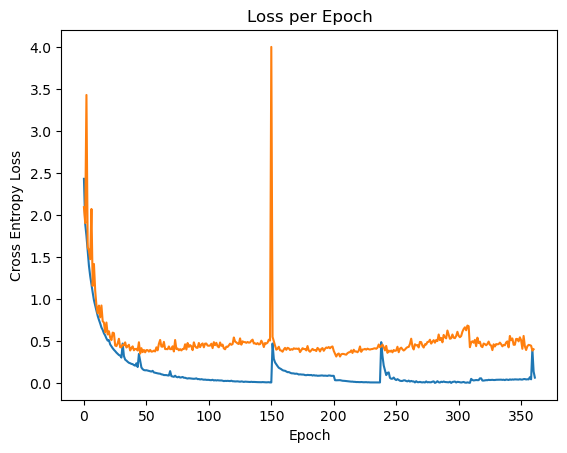

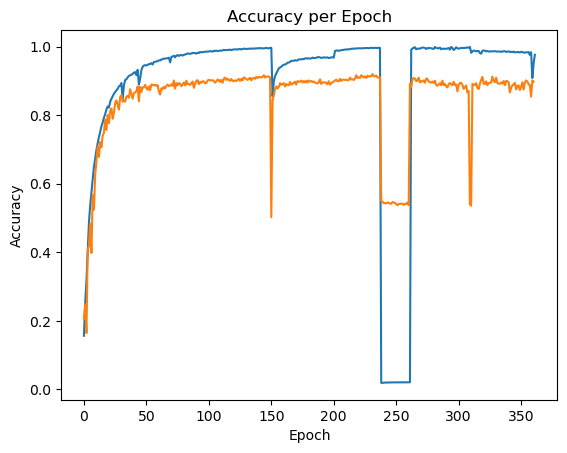

In [93]:
# This graph is from PreActivationResNet34 run 2 using dropout before the linear layer + Image normalization

plt.plot(training_loss_per_epoch, label="training")
plt.plot(val_loss_per_epoch, label="validation")
plt.title("Loss per Epoch")
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.show()

plt.plot(training_acc_per_epoch, label="training")
plt.plot(val_acc_per_epoch, label="validation")
plt.title("Accuracy per Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

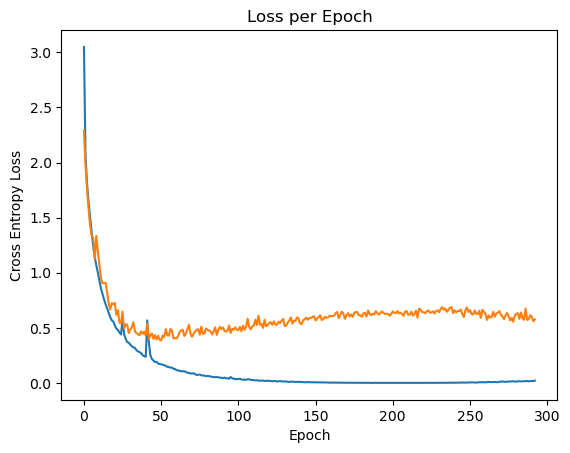

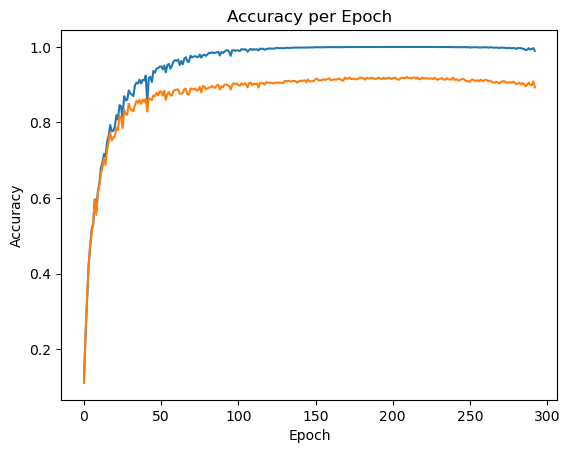

In [ ]:
# This graph is from PreActivationResNet34 run 2 using dropout before the linear layer + Image normalization

plt.plot(training_loss_per_epoch, label="training")
plt.plot(val_loss_per_epoch, label="validation")
plt.title("Loss per Epoch")
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.show()

plt.plot(training_acc_per_epoch, label="training")
plt.plot(val_acc_per_epoch, label="validation")
plt.title("Accuracy per Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

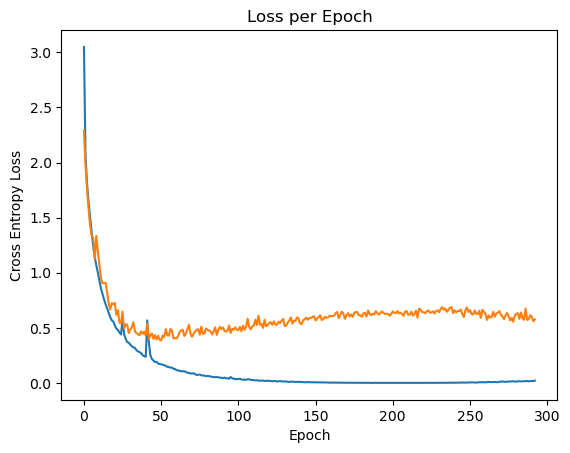

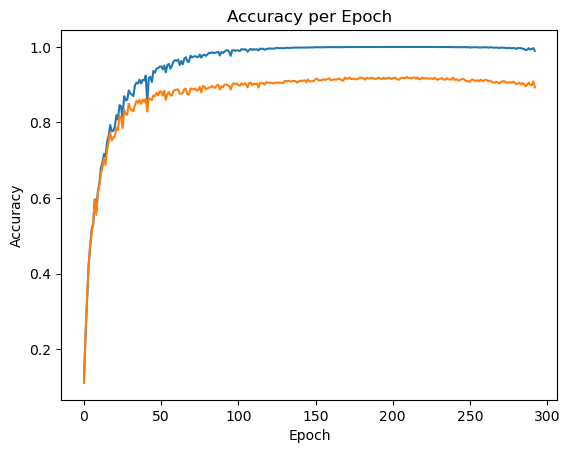

In [51]:
# This graph is from PreActivationResNet run 3 using dropout before the linear layer + Image normalization

plt.plot(training_loss_per_epoch, label="training")
plt.plot(val_loss_per_epoch, label="validation")
plt.title("Loss per Epoch")
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.show()

plt.plot(training_acc_per_epoch, label="training")
plt.plot(val_acc_per_epoch, label="validation")
plt.title("Accuracy per Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

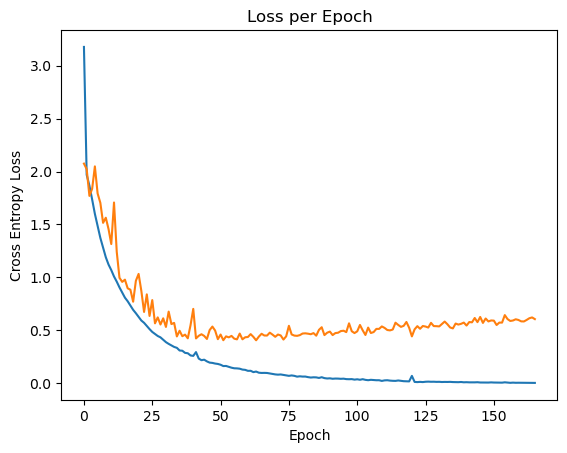

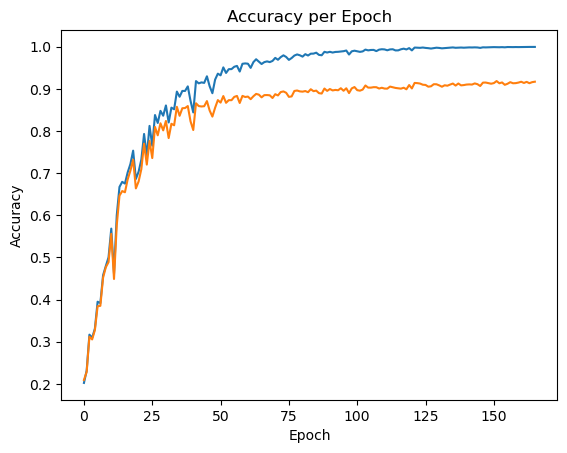

In [38]:
# This graph is from PreActivationResNet run 2 using dropout before the linear layer

plt.plot(training_loss_per_epoch, label="training")
plt.plot(val_loss_per_epoch, label="validation")
plt.title("Loss per Epoch")
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.show()

plt.plot(training_acc_per_epoch, label="training")
plt.plot(val_acc_per_epoch, label="validation")
plt.title("Accuracy per Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

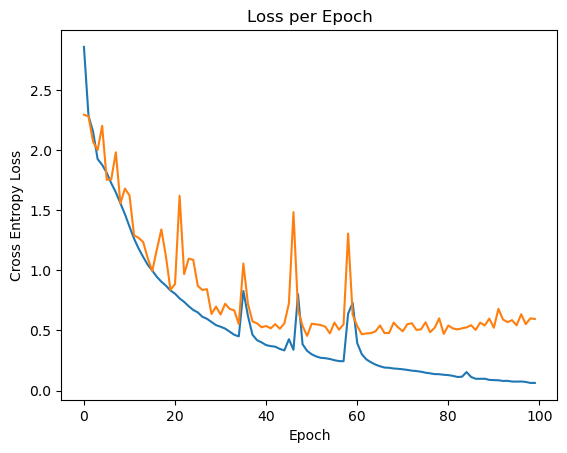

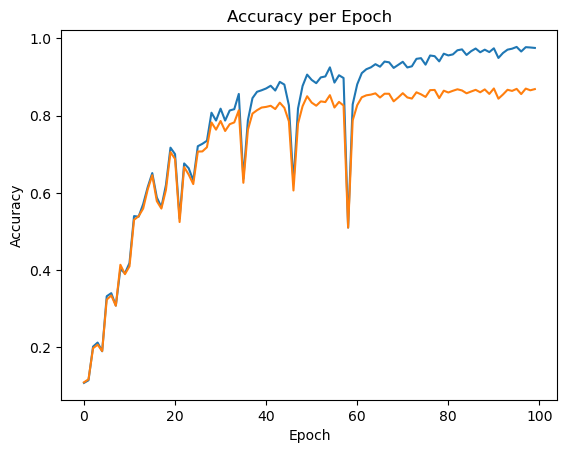

In [233]:
# This graph is from PreActivationResNet34

plt.plot(training_loss_per_epoch, label="training")
plt.plot(val_loss_per_epoch, label="validation")
plt.title("Loss per Epoch")
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.show()

plt.plot(training_acc_per_epoch, label="training")
plt.plot(val_acc_per_epoch, label="validation")
plt.title("Accuracy per Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

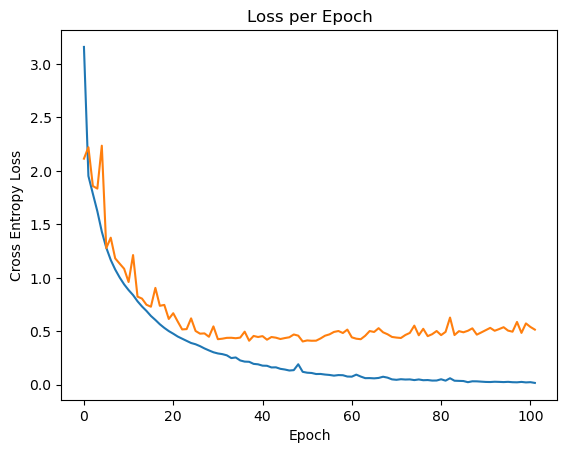

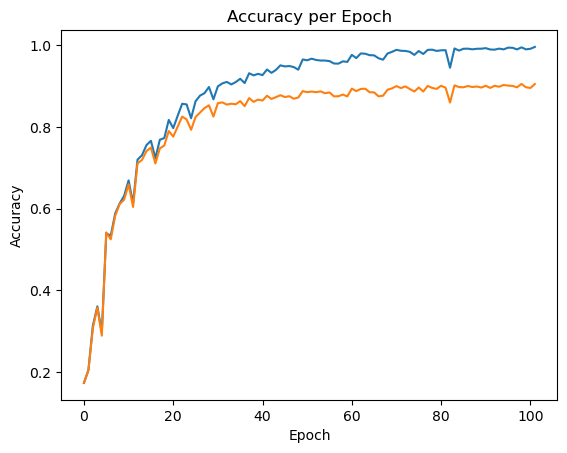

In [189]:
# This graph is from PreActivationResNet

plt.plot(training_loss_per_epoch, label="training")
plt.plot(val_loss_per_epoch, label="validation")
plt.title("Loss per Epoch")
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.show()

plt.plot(training_acc_per_epoch, label="training")
plt.plot(val_acc_per_epoch, label="validation")
plt.title("Accuracy per Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

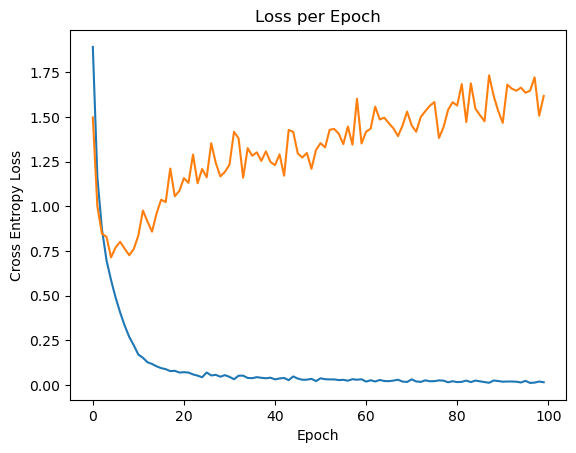

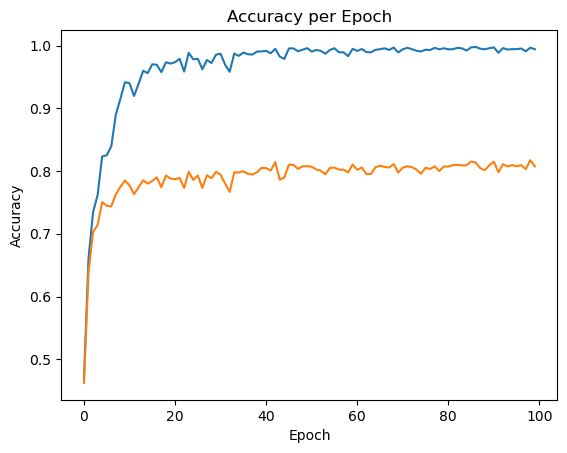

In [124]:
# This graph is from training ResNet, not PreActivationResNet

plt.plot(training_loss_per_epoch, label="training")
plt.plot(val_loss_per_epoch, label="validation")
plt.title("Loss per Epoch")
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.show()

plt.plot(training_acc_per_epoch, label="training")
plt.plot(val_acc_per_epoch, label="validation")
plt.title("Accuracy per Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

### Kaggle Submission
The following code is for you to make your submission to kaggle. Here are the steps you must follow:

1. Upload `cifar_test_data_sp24.npy` to the colab notebook by going to files on the left hand pane, then hitting "upload". This file may take roughly a minute to upload and you should not proceed to the following steps until it has completely finished uploading (students in the past have run into issues where they were accidentally testing on a partially uploaded test set and getting garbage results).
2. Run the following cell to generate the dataset object for the test data. Feel free to modify the code to use the same transforms that you use for the training data. By default, this will re-use the `transform` variable.
3. In the second cell, write code to run predictions on the testing dataset and store them into an array called `predictions`.
4. Run the final cell which will convert your predictions array into a CSV for kaggle.
5. Go to the files pane again, and download the file called `submission.csv` by clicking the three dots and then download.


In [39]:
from PIL import Image
import os

class CIFAR10Test(torchvision.datasets.VisionDataset):

    def __init__(self, transform=None, target_transform=None):
        super(CIFAR10Test, self).__init__(None, transform=transform,
                                      target_transform=target_transform)
        assert os.path.exists("cifar10_test_data_sp24.npy"), "You must upload the test data to the file system."
        self.data = [np.load("cifar10_test_data_sp24.npy", allow_pickle=False)]

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

    def __getitem__(self, index: int):
        img = self.data[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __len__(self) -> int:
        return len(self.data)

# Create the test dataset
testing_data = CIFAR10Test(
    transform=transform, # NOTE: Make sure transform is the same as used in the training dataset.
)

In [40]:
### YOUR CODE HERE ###

# Recommendation: create a `test_dataloader` from torch.utils.data.DataLoader with `shuffle=False` to iterate over the test data in batches.
test_dataloader = torch.utils.data.DataLoader(testing_data, batch_size=100, shuffle=False)
# Store a numpy vector of the predictions for the test set in the variable `predictions`.
predictions = []
with torch.no_grad():
    model.eval()
    for x in test_dataloader:
        x = x.float().to(device)
        pred = model(x)
        pred = torch.argmax(pred, 1)
        pred = pred.detach().cpu().numpy()
        predictions.append(pred)
predictions = np.array(predictions).flatten()

In [41]:
predictions.shape, len(testing_data)

((10000,), 10000)

In [42]:
# This code below will generate kaggle_predictions.csv file. Please download it and submit to kaggle.
import pandas as pd

if isinstance(predictions, np.ndarray):
    predictions = predictions.astype(int)
else:
    predictions = np.array(predictions, dtype=int)
assert predictions.shape == (len(testing_data),), "Predictions were not the correct shape"
df = pd.DataFrame({'Category': predictions})
df.index += 1  # Ensures that the index starts at 1.
df.to_csv('submission6_dropout.csv', index_label='Id')

# Now download the submission.csv file to submit.

Congrats! You made it to the end.

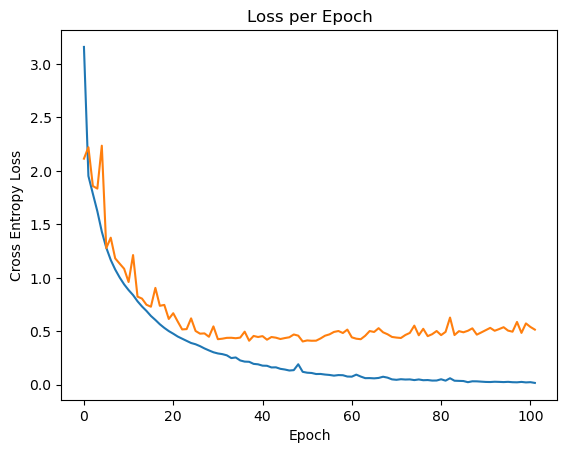

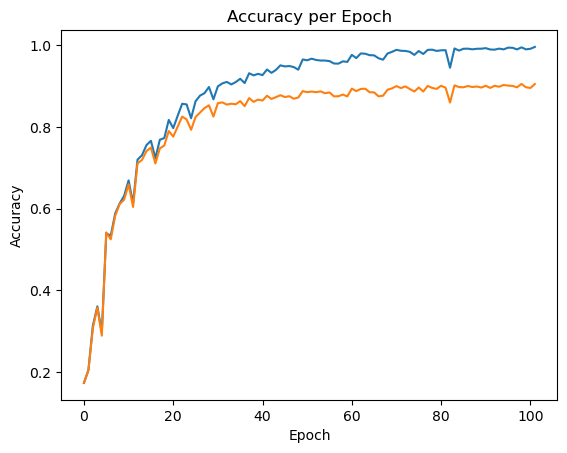

In [ ]:
# This graph is from training PreActivationResNet
# here for safe keeping

plt.plot(training_loss_per_epoch, label="training")
plt.plot(val_loss_per_epoch, label="validation")
plt.title("Loss per Epoch")
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.show()

plt.plot(training_acc_per_epoch, label="training")
plt.plot(val_acc_per_epoch, label="validation")
plt.title("Accuracy per Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

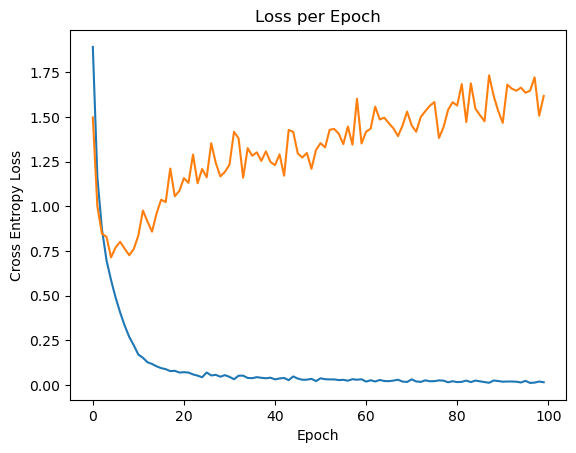

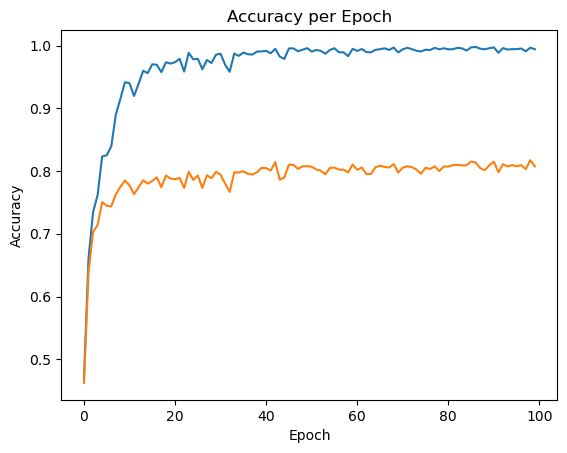

In [ ]:
# This graph is from training ResNet, not PreActivationResNet
# here for safe keeping

plt.plot(training_loss_per_epoch, label="training")
plt.plot(val_loss_per_epoch, label="validation")
plt.title("Loss per Epoch")
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.show()

plt.plot(training_acc_per_epoch, label="training")
plt.plot(val_acc_per_epoch, label="validation")
plt.title("Accuracy per Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()